# Modelling of physical systems - assignment for lab05
## Author: Przemysław Maresz

In [10]:
import numpy as np
from matplotlib import pyplot as plt
from open_atmos_jupyter_utils import show_plot

In [3]:
class shift:
    def __init__(self, *, add, sub):
        self.add = add
        self.sub = sub
    def __radd__(self, i):
        return slice(i.start + self.add, i.stop + self.add)
    def __rsub__(self, i):
        return slice(i.start - self.sub, i.stop - self.sub)

one = shift(add=1, sub=1)
hlf = shift(add=0, sub=1)

def F(psi_l, psi_r, C):
    return .5 * (C + abs(C)) * psi_l + \
           .5 * (C - abs(C)) * psi_r

def upwind(psi, i, C):
    psi[i] = psi[i] - (
        F(psi[i      ], psi[i + one], C[i + hlf]) -
        F(psi[i - one], psi[i      ], C[i - hlf])
    )

In [11]:
def solve_upwind(*, nt: int, C: float, psi: np.ndarray):
    for _ in range(nt):
        upwind(psi, slice(1, len(C)), C)
    return psi

def psi_0(x: np.ndarray, x0: float = 0, a: float = 1, sigma: float = 20):
    return a * np.exp(-(x-x0)**2 / 2 / sigma**2)

def plot(x, **kwargs):
    fig = plt.figure(figsize=(12, 8))
    for label, data in kwargs.items():
        plt.step(x, data, label=label, where='mid')
    plt.legend()
    plt.grid()
    show_plot(fig=fig)

In [7]:
u = 2
t_max = 66

nx = 45
nt = 100
dt = t_max / nt
x, dx = np.linspace(-100, 300, nx, retstep=True)

In [8]:
def corrective_C(psi, C, i):
  return (np.abs(C[i-hlf]) - C[i-hlf]**2) * (psi[i] - psi[i-one]) / (psi[i] + psi[i-one])

def solve_mpdata(*, nt: int, C: float, psi: np.ndarray, num_correct=1):
  for _ in range(nt):
    C_current = C.copy()
    upwind(psi, slice(1, len(C)), C_current)

    for _ in range(num_correct):
      C_current = corrective_C(psi, C_current, slice(1, len(psi)))
      upwind(psi, slice(1, len(C_current)), C_current)

  return psi

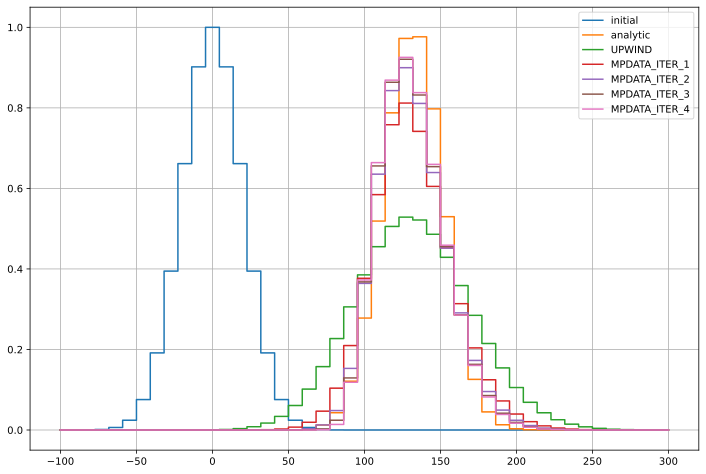

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
plot(
    x=x,
    initial=psi_0(x),
    analytic=psi_0(x-u*t_max),
    UPWIND=solve_upwind(nt=nt, C=np.full(nx-1, u * dt / dx), psi=psi_0(x)),
    MPDATA_ITER_1=solve_mpdata(nt=nt, C=np.full(nx-1, u * dt / dx), psi=psi_0(x), num_correct=1),
    MPDATA_ITER_2=solve_mpdata(nt=nt, C=np.full(nx-1, u * dt / dx), psi=psi_0(x), num_correct=2),
    MPDATA_ITER_3=solve_mpdata(nt=nt, C=np.full(nx-1, u * dt / dx), psi=psi_0(x), num_correct=3),
    MPDATA_ITER_4=solve_mpdata(nt=nt, C=np.full(nx-1, u * dt / dx), psi=psi_0(x), num_correct=4)
)

## Results


#### Iteration 0 (Upwind)

The initial upwind method produces a solution that is significantly diffused. The sharp Gaussian profile is noticeably smoothed and shifted, due to the inherent numerical diffusion error.

#### Iteration 1 (MPDATA_ITER_1)

The first corrective iteration applies an anti-diffusive step. This iteration effectively reduces much of the numerical diffusion, leading to a profile that is noticeably closer to the analytical solution, with a sharper front than the pure upwind result.

#### Iteration 2 (MPDATA_ITER_2)

With the second correction, further refinement is observed. The profile continues to sharpen and match the analytical solution even more closely. The corrective term now minimizes the remaining diffusive effects left by the first iteration.

#### Iteration 3 (MPDATA_ITER_3)

At this stage, the profile has almost converged to the analytic shape. The corrected solution shows very little remaining diffusion, indicating that the majority of the error has been compensated. The improvement compared to the previous iteration is modest.

#### Iteration 4 (MPDATA_ITER_4)

The fourth iteration produces only marginal improvements over iteration 3. The profile remains almost identical to that of the third iteration, suggesting that the solution has essentially converged and further corrections are unnecessary.